In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib
import cartopy as cart
import statistics
from scipy import stats

In [2]:
prw_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_prw_33model_piControl_2x2_last250.nc')

precip_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_pr_39model_piControl_2x2_last250.nc')

land_mask = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_landmask_31model.nc')

tas_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_tas_piControl_2x2_48mod_last250.nc')

ts_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_ts_39model_piControl_2x2_last250.nc')

In [3]:
mask = land_mask.mean('name')

In [4]:
def binning(var,models,temp_var,varname,temp_type,mini,maxi,xmin,xmax,yminl,ymaxl,yminr,ymaxr,nrow,ncol):
    var_mean = var.sel(name=models).isel(time=slice(len(var.time)-(30*12),
                                         len(var.time))).sel(lat=slice(-30,30)).mean('time').mean('name').to_dataset()
    
           
    if temp_var.equals(ts_var):
        temp_label = r'Binned Mean 10 year Local TS $\sigma$ [K]'
    else:
        temp_label = r'Binned Mean 10 year Local TAS $\sigma$ [K]'
        
    if temp_type == 'ts':
        var_mean = var_mean.where(mask<50)
        temp_var = temp_var.where(mask<50)
        print('TS masked')
        
    bin_edges = np.linspace(mini,maxi,15)
    print(bin_edges)
    
    var_mean['temp'] = temp_var
    var_mean_stack = var_mean.stack(z=('lat','lon'))
    var_mean_stack['tags'] = pd.cut(var_mean_stack[varname], bins=bin_edges, labels=bin_edges[:-1])
    var_mean_stats = var_mean_stack.groupby('tags').groups
    
    var_mean_binned = []
    var_std_binned = []
    for group in var_mean_stats:
        var_list = []
        for index in var_mean_stats[group]:
            var_list.append(var_mean_stack.temp[index].item())
        var_mean_binned.append(np.nanmean(var_list))
        var_std_binned.append(np.nanstd(var_list))
        
    #plt.rcParams['figure.figsize'] = [12, 7]
    #fig, ax1 = plt.subplots()
    ax1 = fig.add_subplot(gs[nrow,ncol])
    ax1.errorbar(var_mean_stats.keys(), var_mean_binned, var_std_binned, capsize=5)
    ax1.scatter(var_mean_stats.keys(), var_mean_binned)
    ax1.set_ylabel(temp_label)
    ax1.set_ylim(yminl,ymaxl)
    ax1.set_xlim(mini,maxi)
    #ax1.set_ylim(0.025,0.225)

    ax2 = ax1.twinx()
    gkde = stats.gaussian_kde(var_mean_stack[varname][~np.isnan(var_mean_stack[varname])])
    pdf = gkde.evaluate(np.linspace(var_mean_stack[varname].min(), var_mean_stack[varname].max(),200))
    #ax2.hist(omega_cont_mean_stack_tas['wap'], bin_edges_tas, density=True)
    ax2.plot(np.linspace(var_mean_stack[varname].min(), var_mean_stack[varname].max(), 200), pdf, color='orange')
    ax2.set_ylabel(varname + '  Distribution')
    ax2.set_ylim(yminr,ymaxr)
    ax2.set_xlim(xmin,xmax)

    ax1.set_xlabel(varname)

TS masked
[ 0.          3.57142857  7.14285714 10.71428571 14.28571429 17.85714286
 21.42857143 25.         28.57142857 32.14285714 35.71428571 39.28571429
 42.85714286 46.42857143 50.        ]


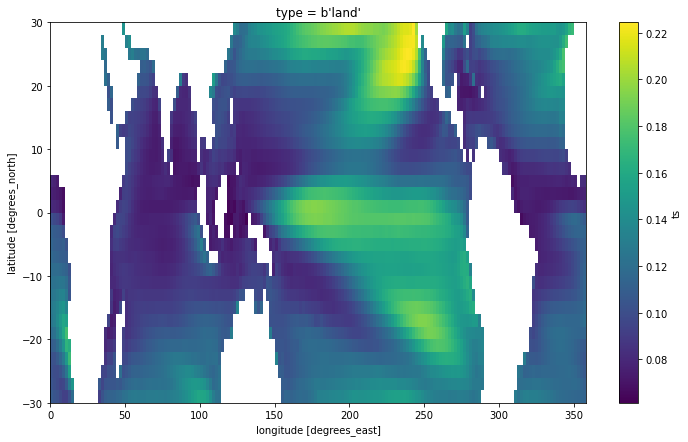

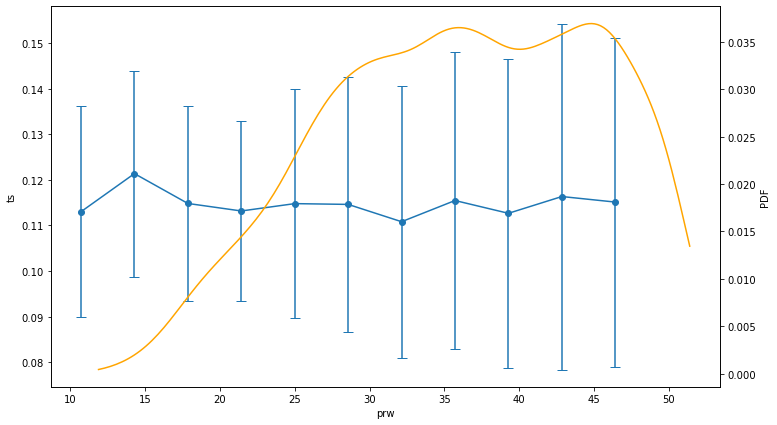

In [14]:
# TS - Original with Plot
binning(prw_cont,models_prw_TS,30,ts_cont,'prw','ts',0,50)

TS masked
[ 0.          3.57142857  7.14285714 10.71428571 14.28571429 17.85714286
 21.42857143 25.         28.57142857 32.14285714 35.71428571 39.28571429
 42.85714286 46.42857143 50.        ]


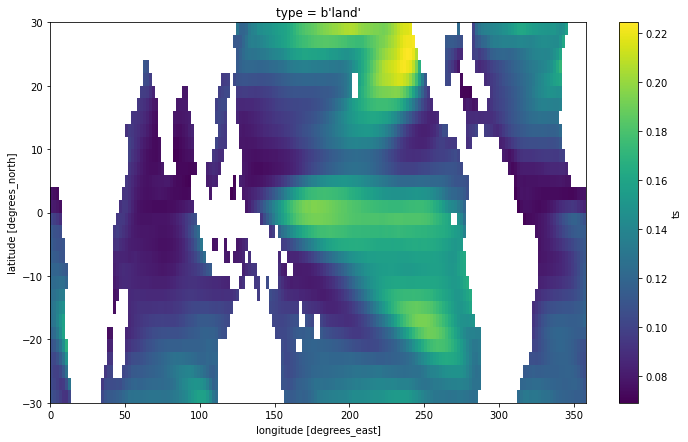

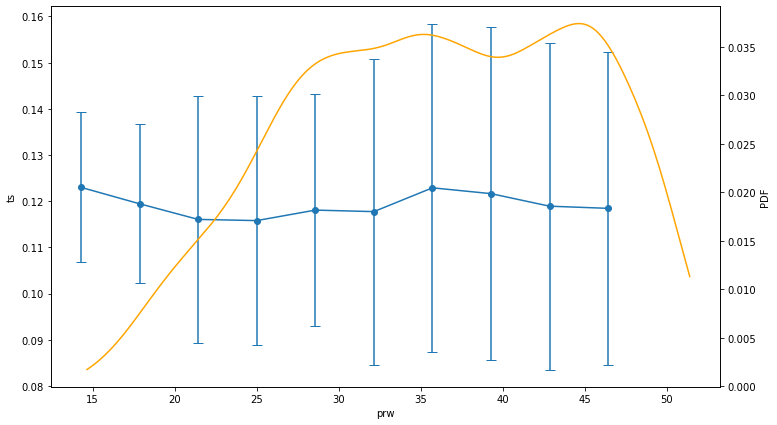

In [16]:
# TS - mask < 2
binning(prw_cont,models_prw_TS,30,ts_cont,'prw','ts',0,50)

# PRW

In [5]:
models_prw = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2',
              'CESM2-WACCM','CESM2-WACCM-FV2','CIESM','E3SM-1-0','EC-Earth3','EC-Earth3-Veg-LR','FGOALS-g3','GFDL-CM4',
              'GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','MIROC6',
              'MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-MM','SAM0-UNICON','TaiESM1']

## -30 to 30

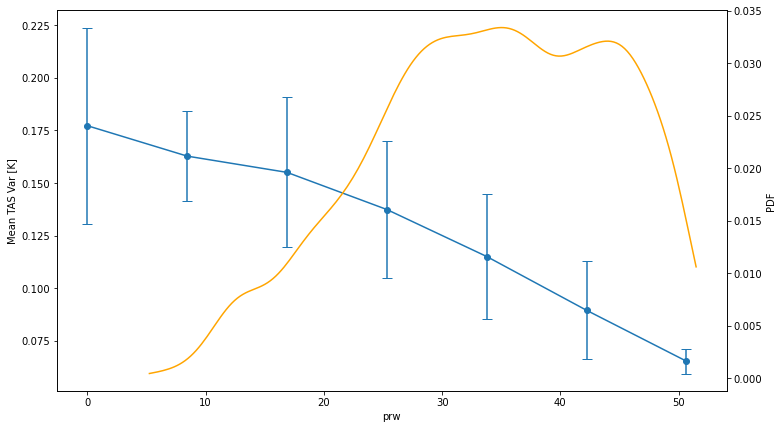

In [14]:
# TAS
binning(prw_cont,models_prw,30,tas_cont,'prw','tas')

In [6]:
models_prw_TS = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2',
              'CESM2-WACCM','CESM2-WACCM-FV2','CIESM','E3SM-1-0','EC-Earth3','EC-Earth3-Veg-LR','FGOALS-g3','GFDL-CM4',
              'GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','MIROC6',
              'MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-MM','SAM0-UNICON','TaiESM1']

TS masked


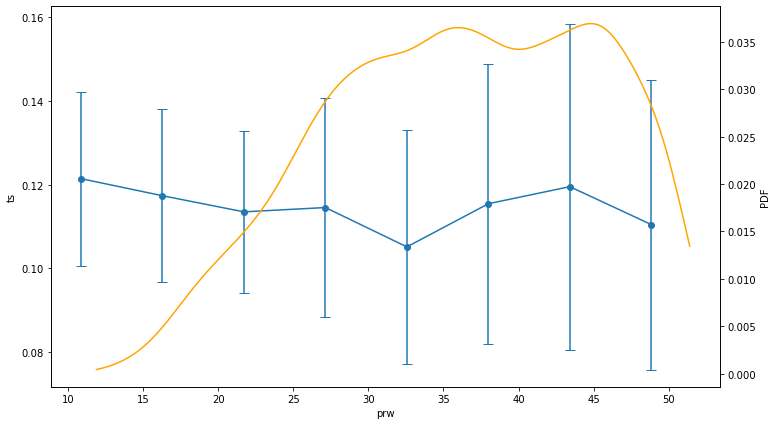

In [25]:
# TS
binning(prw_cont,models_prw_TS,30,ts_cont,'prw','ts')

TS masked
[ 0.          3.57142857  7.14285714 10.71428571 14.28571429 17.85714286
 21.42857143 25.         28.57142857 32.14285714 35.71428571 39.28571429
 42.85714286 46.42857143 50.        ]


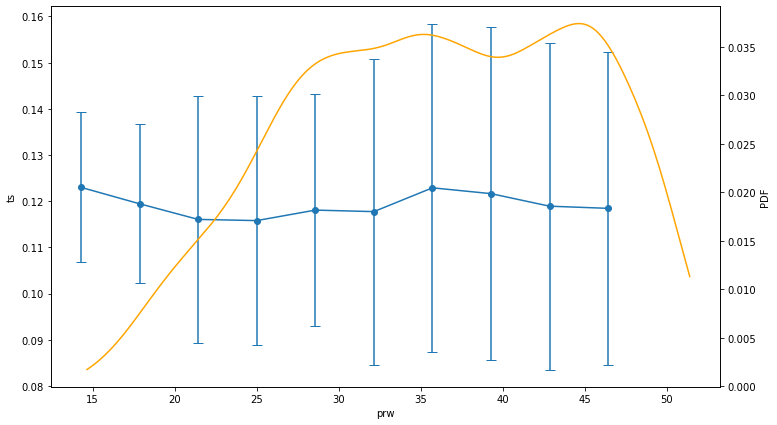

In [9]:
# TS
binning(prw_cont,models_prw_TS,30,ts_cont,'prw','ts',0,50)

## -20 to 20

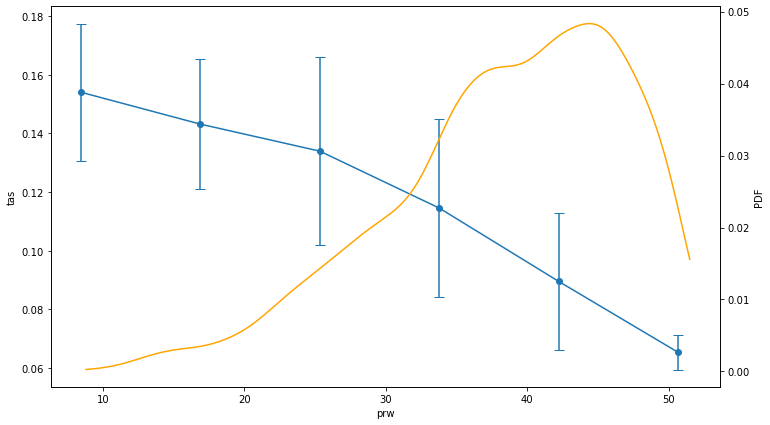

In [21]:
# TAS
binning(prw_cont,models_prw,20,tas_cont,'prw','tas')

TS masked


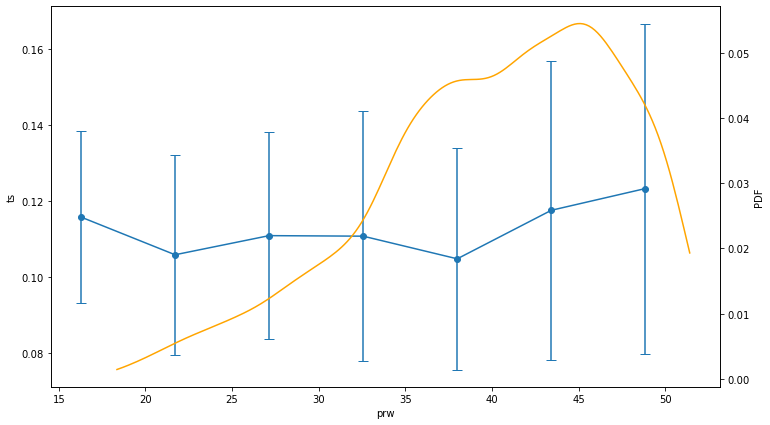

In [27]:
# TS
binning(prw_cont,models_prw_TS,20,ts_cont,'prw','ts')

# TS

In [7]:
models_ts = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2',
             'CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','CMCC-ESM2','E3SM-1-0','E3SM-1-1',
             'EC-Earth3','EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4',
             'GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8','INM-CM5-0','IPSL-CM5A2-INCA','IPSL-CM6A-LR','MIROC6',
             'MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-LM','NorESM2-MM','SAM0-UNICON','TaiESM1']

## -30 to 30

[275.  277.5 280.  282.5 285.  287.5 290.  292.5 295.  297.5 300.  302.5
 305.  307.5 310. ]


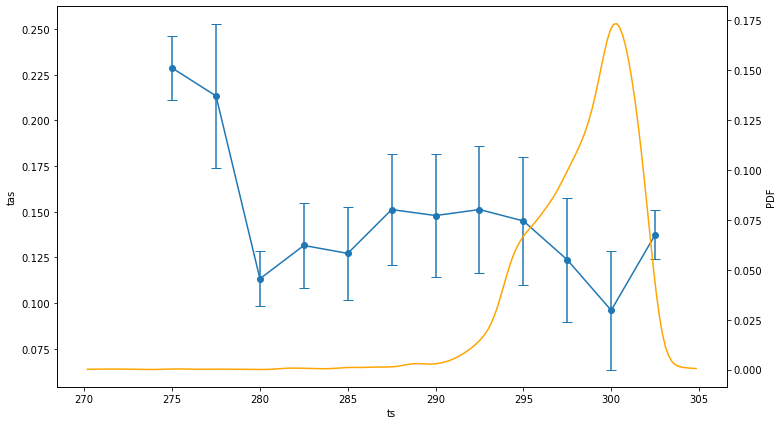

In [9]:
# TAS
binning(ts_cont, models_ts,30,tas_cont,'ts','tas',275,310)

TS masked
[290.         291.42857143 292.85714286 294.28571429 295.71428571
 297.14285714 298.57142857 300.         301.42857143 302.85714286
 304.28571429 305.71428571 307.14285714 308.57142857 310.        ]


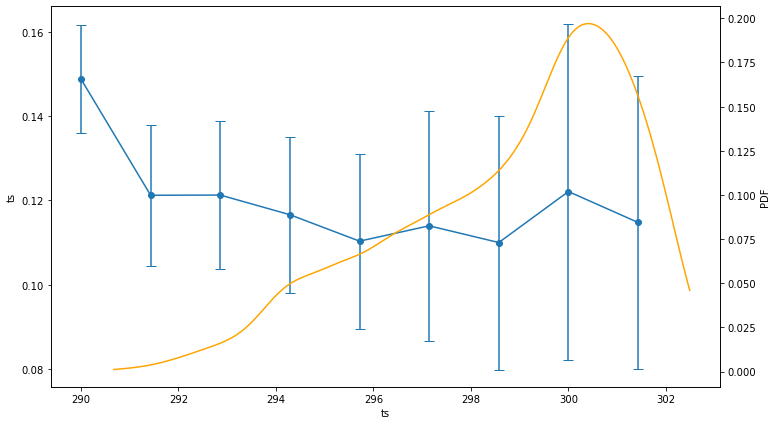

In [11]:
# TS
binning(ts_cont, models_ts,30,ts_cont,'ts','ts',290,310)

## -20 to 20

[275.  277.5 280.  282.5 285.  287.5 290.  292.5 295.  297.5 300.  302.5
 305.  307.5 310. ]


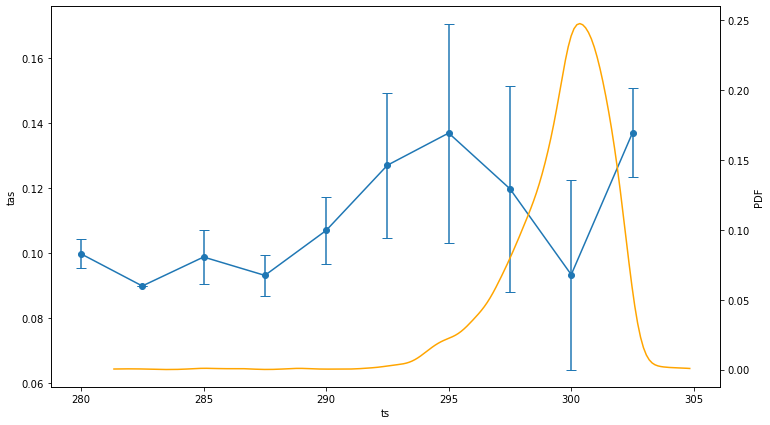

In [12]:
# TAS
binning(ts_cont, models_ts,20,tas_cont,'ts','tas',275,310)

TS masked
[290.         291.42857143 292.85714286 294.28571429 295.71428571
 297.14285714 298.57142857 300.         301.42857143 302.85714286
 304.28571429 305.71428571 307.14285714 308.57142857 310.        ]


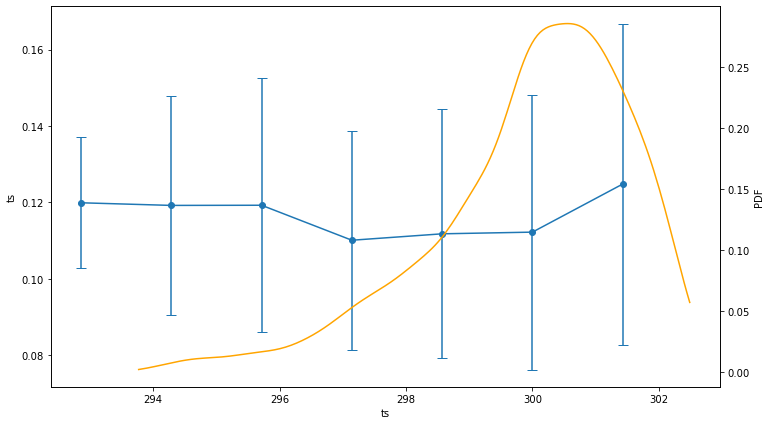

In [13]:
# TS
binning(ts_cont, models_ts,20,ts_cont,'ts','ts',290,310)

# PR

In [8]:
models_pr = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2',
             'CESM2-WACCM','CESM2-WACCM-FV2','CMCC-CM2-SR5','CMCC-ESM2','E3SM-1-0','E3SM-1-1','EC-Earth3','EC-Earth3-AerChem',
             'EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8',
             'INM-CM5-0','IPSL-CM5A2-INCA','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1',
             'NorESM2-LM','NorESM2-MM','SAM0-UNICON','TaiESM1']

## -30 to 30

[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


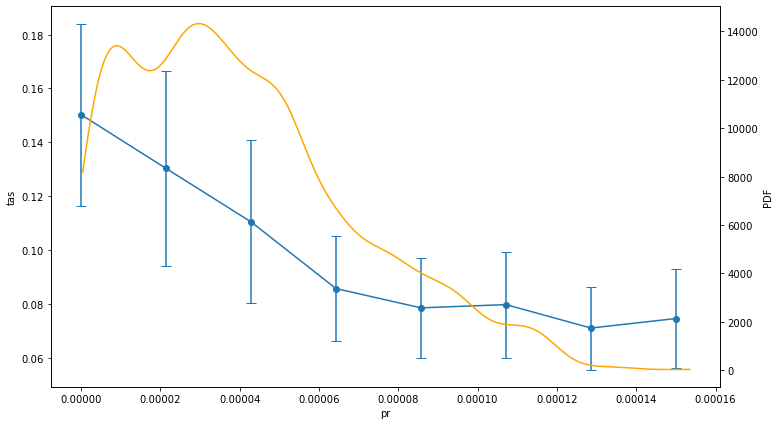

In [15]:
# TAS
binning(precip_cont, models_pr, 30, tas_cont, 'pr', 'tas', 0, 0.0003)

TS masked
[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


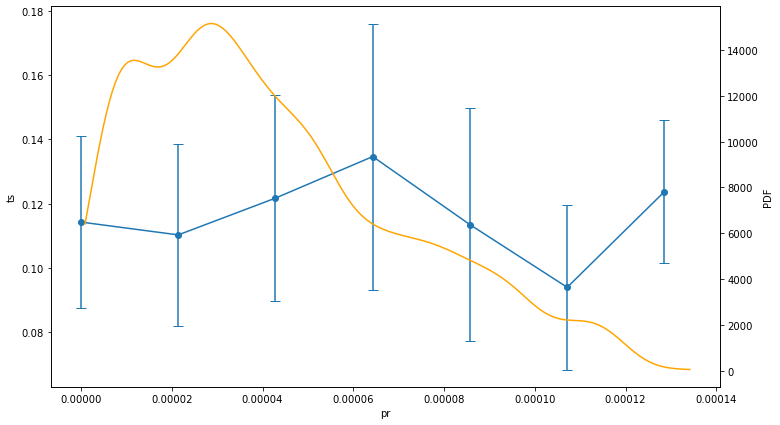

In [16]:
# TS
binning(precip_cont, models_pr, 30, ts_cont, 'pr', 'ts', 0, 0.0003)

## -20 to 20

[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


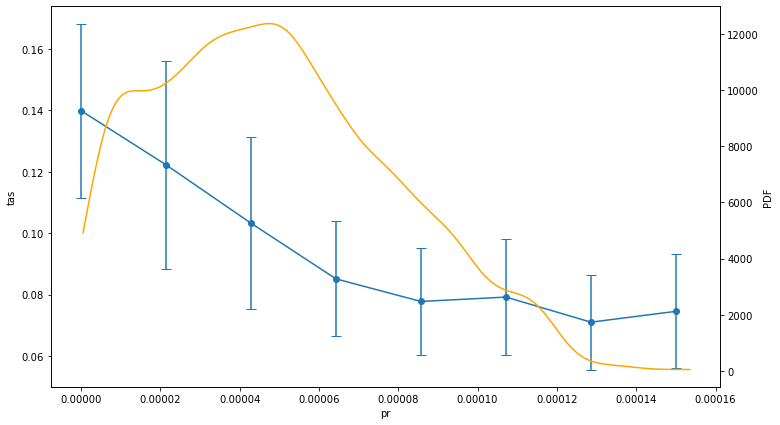

In [17]:
# TAS
binning(precip_cont, models_pr, 20, tas_cont, 'pr', 'tas', 0, 0.0003)

TS masked
[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


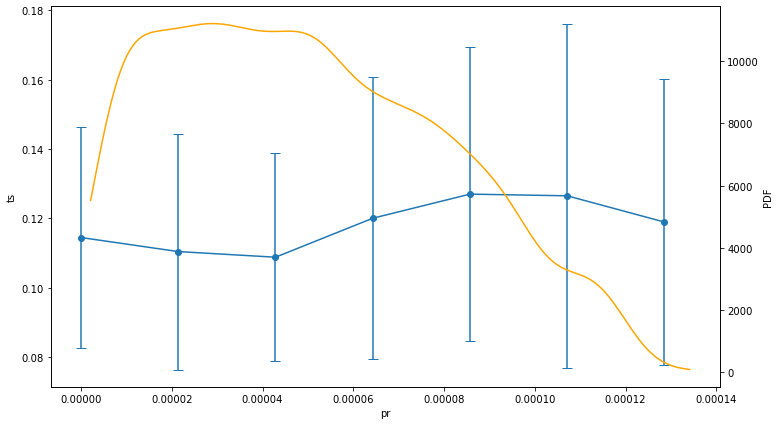

In [18]:
# TS
binning(precip_cont, models_pr, 20, ts_cont, 'pr', 'ts', 0, 0.0003)

In [5]:
models = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2',
          'CESM2-WACCM','CESM2-WACCM-FV2','EC-Earth3','EC-Earth3-Veg-LR','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G',
          'INM-CM4-8','INM-CM5-0','MIROC6','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-MM','SAM0-UNICON','TaiESM1']

In [6]:
ts_rolling = ts_cont.sel(name=models).rolling(time=120, center=True).mean('time')
ts_std = ts_rolling.std('time')
ts_var = ts_std.mean('name').sel(lat=slice(-30,30))

tas_rolling = tas_cont.sel(name=models).rolling(time=120, center=True).mean('time')
tas_std = tas_rolling.std('time')
tas_var = tas_std.mean('name').sel(lat=slice(-30,30))

[ 0.          4.28571429  8.57142857 12.85714286 17.14285714 21.42857143
 25.71428571 30.         34.28571429 38.57142857 42.85714286 47.14285714
 51.42857143 55.71428571 60.        ]
TS masked
[ 0.          4.28571429  8.57142857 12.85714286 17.14285714 21.42857143
 25.71428571 30.         34.28571429 38.57142857 42.85714286 47.14285714
 51.42857143 55.71428571 60.        ]
TS masked
[275.  277.5 280.  282.5 285.  287.5 290.  292.5 295.  297.5 300.  302.5
 305.  307.5 310. ]
TS masked
[290.         291.42857143 292.85714286 294.28571429 295.71428571
 297.14285714 298.57142857 300.         301.42857143 302.85714286
 304.28571429 305.71428571 307.14285714 308.57142857 310.        ]
[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]
TS masked
[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.571428

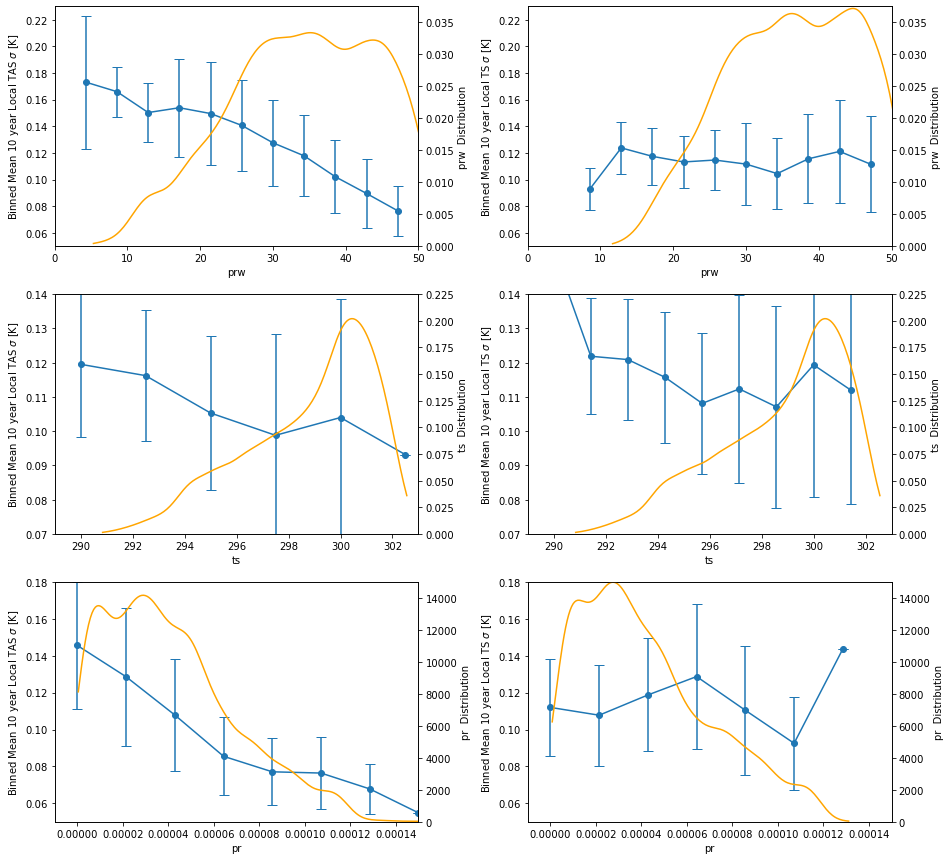

In [7]:
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(nrows=3,ncols=2)
gs.update(wspace=0.3)
font = {'size'   : 20,
        'weight' : 'normal'}

binning(prw_cont,models,tas_var,'prw','tas',0,60,0,50,0.05,0.23,0,0.0375,0,0)
binning(prw_cont,models,ts_var,'prw','ts',0,60,0,50,0.05,0.23,0,0.0375,0,1)

binning(ts_cont,models,tas_var,'ts','ts',275,310,289,303,0.07,0.14,0,0.225,1,0)
binning(ts_cont,models,ts_var,'ts','ts',290,310,289,303,0.07,0.14,0,0.225,1,1)

binning(precip_cont,models,tas_var, 'pr', 'tas', 0, 0.0003,-0.00001,0.00015,0.05,0.18,0,15000,2,0)
binning(precip_cont,models,ts_var, 'pr', 'ts', 0, 0.0003,-0.00001,0.00015,0.05,0.18,0,15000,2,1)